In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
import scipy.linalg as la
from scipy.interpolate import interp1d
import sys
if ".." not in sys.path: sys.path.append("..")
from common import constants, cosmology

# $\mathrm{B} - \mathrm{L}$ Genesis

## Warning: for different epoch change numbers!

In [2]:
g2 = 0.55
g3 = 0.6

def g_to_alpha(g): return (g / (4*np.pi))**2

alpha_2 = g_to_alpha(g2)
alpha_3 = g_to_alpha(g3)

Y_tau = 1e-2
Y_top = 0.49
Y_bottom = 6.8e-3

kappa_tau = 1.7e-3

def calc_yukawa_rate(T, kappa, Y):
    return kappa * Y**2 * T**4

def calc_yukawa_rate_tau(T):
    return calc_yukawa_rate(T, kappa_tau, Y_tau)

# log log -> no
# log linear -> no

kappa_quarks = np.array([8e-3, 1e-2, 1.2e-2])
T_for_kappa_quarks = np.array([1e15, 1e12, 1e9])
kappa_quark_interp = interp1d(T_for_kappa_quarks, kappa_quarks)

def calc_yukawa_rate_quark(T, Y):
    kappa = kappa_quarks[1] # kappa_quark_interp(T)
    return calc_yukawa_rate(T, kappa, Y)

def calc_yukawa_rate_top(T):
    return calc_yukawa_rate_quark(T, Y_top)

def calc_yukawa_rate_bottom(T):
    return calc_yukawa_rate_quark(T, Y_bottom)

In [3]:
def calc_sphaleron_rate(T, N_H, N_c
                        , alpha, N_f=6):
    some_number = 3.041
    g = np.sqrt(4*np.pi*alpha)
    m_D = np.sqrt((2*N_c + N_f + N_H) / 6 * g**2 * T**2)

    def gamma_eq(gamma):
        return gamma - N_c * alpha * T * (np.log(m_D / gamma) + some_number)
    p = - some_number * N_c * alpha * T
    q = - N_c * alpha * T * m_D
    guess = -p/2 + np.sqrt((p/2)**2 - q)
    sol = root(gamma_eq, guess)
    if not sol.success: return np.nan
    gamma = sol.x[0]

    Gamma_sphal = ( 
        0.21 / 2 * (N_c * g**2 * T**2 / m_D**2) * 
        (np.log(m_D / gamma) + some_number) * 
        (N_c**2 - 1) / N_c**2 * 
        (N_c * alpha)**5 * T**4
    )
    return Gamma_sphal

kappa_WS = 24 # for 1e12 GeV
kappa_SS = 2.7e2 # for 1e13 GeV

def calc_weak_sphaleron_rate(T):
    return kappa_WS / 2 * alpha_2**5 * T**4
    # return calc_sphaleron_rate(T, N_H=1, N_c=2, alpha=alpha2_running(T))

def calc_strong_sphaleron_rate(T):
    return kappa_SS / 2 * alpha_3**5 * T**4
    # return calc_sphaleron_rate(T, N_H=0, N_C=3, alpha=alpha3_running(T))

In [4]:
charge_vector = np.array((
    # Interactions:
    # tau, L12, L3, q12, t,  b,  Q12, Q3,  H
    (0,    2,   1,  0,   0,  0,  6,   3,   0), # WS
    (0,    0,   0, -4,  -1, -1,  4,   2,   0), # SS
    (-1,   0,   1,  0,   0,  0,  0,   0,   1), # Y_tau
    (0,    0,   0,  0,  -1,  0,  0,   1,   1), # Y_top
    (0,    0,   0,  0,   0, -1,  0,   1,  -1), # Y_bottom
    (0,    2,   0,  0,   0,  0,  0,   0,   2), # Weinberg_12
    (0,    0,   2,  0,   0,  0,  0,   0,   2), # Weinberg_3
    # Conserved Quantaties:
    # tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
    #( -1, -1/2, -1/2,  1/6,  2/3, -1/3, 1/6,  1/6, 1/2), # Y
    #(  0,  0,    0,    1/3, -2/3, -2/3, 1/3, -2/3, 0),   # B12 - 2*B3
))

In [5]:
g = dofs = np.array([1,4,2,12,3,3,12,6,4])

In [6]:
kappa_W = 3e-3
nu_EW = 174 # [GeV]
m_nu = 0.05 # np.sqrt(2.4e-3)
def calc_weinberg_op_rate(T):
    return kappa_W * m_nu**2 * T**6 / nu_EW**4

In [7]:
def calc_rate_vector(T):
    return np.array((
        calc_weak_sphaleron_rate(T), # WS
        calc_strong_sphaleron_rate(T), # SS
        calc_yukawa_rate_tau(T), # Y_tau
        calc_yukawa_rate_top(T), # Y_top
        calc_yukawa_rate_bottom(T), # Y_bottom
        calc_weinberg_op_rate(T), # W_12 # CORRECT?
        calc_weinberg_op_rate(T), # W_3
    ))

In [8]:
#                                           WS SS  Ytau Yt Yb  W12  W3 
source_vector_B_minus_L_current = np.array((0,  0,  0,  0,  0, -2, -2))
source_vector_weak_sphaleron    = np.array((1,  0,  0,  0,  0,  0,  0))
source_vector_strong_sphaleron  = np.array((0,  1,  0,  0,  0,  0,  0))

In [9]:
initial_chemical_potentials = np.zeros(charge_vector.shape[1])
T_RH = 1e15

# a dot / f / T
eta0 = -1e-9
def calc_axion_motion(T):
    return eta0

In [82]:
# red_chem = reduced chemical potential = mu / T = chemical potetial / temperature
inv_red_chem_unit = 1e15

In [83]:
def transport_eq_rhs(log_T, red_chem_pot, n_S, n):
    T = np.exp(log_T)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    gamma = calc_rate_vector(T) / (T**3 / 6)
    axion_motion = calc_axion_motion(T) * inv_red_chem_unit
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (np.dot(n[alpha, :], red_chem_pot) - n_S[alpha] * axion_motion) 
                        for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    return d_red_chem_pot_d_ln_T

In [84]:
start = np.log(T_RH)
end = np.log(1e10)
num_steps = 500
steps = np.linspace(start, end, num_steps)
steps[0] = start; steps[-1] = end

In [85]:
sol = solve_ivp(transport_eq_rhs, (start, end), initial_chemical_potentials, 
         args=(source_vector_weak_sphaleron, charge_vector), 
         method="BDF", rtol=1e-5, t_eval=steps)

In [86]:
charge_names = ["tau", "L12", "L3", "q12", "t", "b", "Q12", "Q3", "H"]

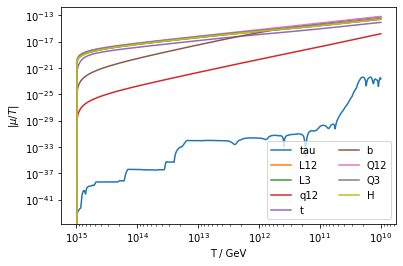

In [87]:
for name, y in zip(charge_names, sol.y):
    plt.loglog(np.exp(sol.t), np.abs(y) / inv_red_chem_unit, label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)